In [0]:
import numpy as np
import pandas as pd
import csv
from numpy import set_printoptions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Seaborn visualization library - for EDA (Exploratory Data Analysis)
import seaborn as sns

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [9]:
ls "/content/gdrive/My Drive/COMP 642/proj"

'Drilling Parameter Inputs.JPG'   visualization_highres.png   well_1.csv
 EDR_preprocessing.ipynb          visualization_lowres.png
'EDS_COMP 642 proj-Copy1.ipynb'   well_1b.csv


In [0]:
path = "/content/gdrive/My Drive/COMP 642/proj/"
fn1= "well_1.csv"

with open(path + fn1, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    data_input = np.array(list(reader))

In [0]:
#Need to select proper features - addressed with data input stream - feature selection.

#Convert string data (imported from CSV) to float
data = data_input.astype(float)

#Need to perform feature addition. 
#Add a feature (Bit depth) / (Hole Depth) that serves as a ratio or a 'locator' of where we are during trip.
depth_ratio = data[:,1]/data[:,0]
dr_col = np.expand_dims(depth_ratio, axis=1)
X = np.hstack((dr_col, data))
headers.insert(0, "Bit Depth / Hole Depth")

#Need to correct inputs to 0 if applicable. (differential pressure - col index = 7)
diff = X[:,7]
diff[diff<0] = 0
X[:,7] = diff

In [12]:
print(headers)

['Bit Depth / Hole Depth', 'Hole Depth', 'Bit Depth', 'Rotary RPM', 'Weight on Bit', 'Total Pump Output', 'Block Height', 'Differential Pressure', 'Hook Load', 'On Bottom ROP', 'On Bottom Hours', 'Standpipe Pressure', 'Convertible Torque']


In [0]:
np.set_printoptions(precision=2,suppress = True, edgeitems=50, floatmode='maxprec', linewidth=np.inf)
#print(headers)
#print(X)

In [0]:
pl = StandardScaler()
X_train = pl.fit_transform(X)

In [0]:
#Convert data to a dataframe to make for more convenient inspection, and also for plotting.
dataframe = pd.DataFrame(data = X, columns=headers)

In [16]:
dataframe

,Bit Depth / Hole Depth,Hole Depth,Bit Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Height,Differential Pressure,Hook Load,On Bottom ROP,On Bottom Hours,Standpipe Pressure,Convertible Torque
0,0.076040,2525.0,192.0,0.05,0.0,0.00,12.0,0.00,46.8,0.0,98.83,0.00,0.0
1,0.076040,2525.0,192.0,0.05,0.0,0.00,33.8,0.00,48.4,0.0,98.83,0.00,0.0
2,0.076040,2525.0,192.0,0.05,0.0,0.00,39.4,0.00,48.9,0.0,98.83,0.00,0.0
3,0.076040,2525.0,192.0,0.05,0.0,0.00,39.1,0.00,55.5,0.0,98.83,0.00,0.0
4,0.076040,2525.0,192.0,0.05,0.0,0.00,30.4,0.00,53.1,0.0,98.83,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33979,0.999026,21565.1,21544.1,0.08,0.0,328.19,47.0,233.41,47.8,0.0,74.04,3432.08,0.0
33980,0.999026,21565.1,21544.1,0.08,0.0,107.91,47.0,0.00,47.8,0.0,74.04,2693.37,0.0
33981,0.999026,21565.1,21544.1,0.08,0.0,0.00,47.0,0.00,47.8,0.0,74.04,854.40,0.0
33982,0.999026,21565.1,21544.1,0.08,0.0,0.00,47.0,0.00,47.8,0.0,74.04,505.61,0.0


In [0]:
#grid = sns.FacetGrid(dataframe, col="Hole Depth")
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10)
X_clustered = kmeans.fit_predict(X_train)

In [0]:
#KMeans clustering - check for the optimal number of clusters (by elbow method with inertia).
#See how many clusters that is, and if they have a meaningful representation in drilling. 
def elbow_method(data, low, high, inertia_set):
  for i in range(low, high + 1):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(data)
    inertia_set.append(km.inertia_)
  plt.plot(range(low, high + 1), inertia_set, marker='o')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.tight_layout()
  plt.show()


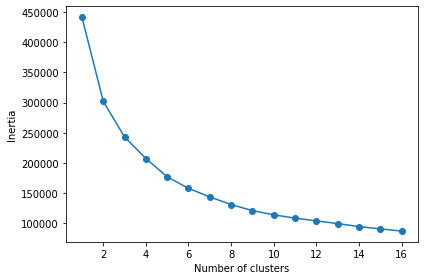

In [19]:
inertia_original = []
elbow_method(X_train, 1, 16, inertia_original)

In [20]:
centroids = kmeans.cluster_centers_
centroid_params = pl.inverse_transform(centroids)
centroid_params_df = pd.DataFrame(data = centroid_params, columns=headers)
centroid_params_df

,Bit Depth / Hole Depth,Hole Depth,Bit Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Height,Differential Pressure,Hook Load,On Bottom ROP,On Bottom Hours,Standpipe Pressure,Convertible Torque
0,0.983020,18762.486290,18396.466164,88.007219,27.291076,337.792332,63.221809,431.362633,217.962798,1.045270e+02,48.077249,5297.633014,13.138274
1,0.997597,9654.803682,9623.578473,28.586084,18.683471,272.695681,53.618575,376.365773,183.342341,3.885303e+01,23.888182,2818.038308,6.636195
2,0.463957,14013.725385,6743.664145,0.847309,70.479776,3.834067,75.908684,0.097890,102.625483,2.238210e-12,37.215502,31.676800,0.506768


In [0]:
#Revised/Advanced feature selection and preprcessing using clustering.
#after assessing original clustering Performance. 
#This is to make a significant impact on clustering inertia, which should lead to higher performing 
#Remove bit depth and hole depth. After we have the ratio, the actual depths are not relevant for on-bottom parameters. 
#Remove on-bottom hours. not relevant for potential on-bottom algorithms. 
X_dr = np.delete(X, [1,2,10], 1)
headers_dr = [x for x in headers if x not in ["Hole Depth", "Bit Depth", "On Bottom Hours"]]


#Do we need block height? probably not as an absolute number. Instead, use a measure of velocity. 
block_height = np.zeros(X.shape[0])
block_height[0] = 0
dh = np.zeros(X.shape[0])
dh[0] = 0
for i in range(1, X.shape[0]):
  dh[i] = X[i,6] - X[i-1,6]
  if dh[i] < 1 and dh[i] > -1:
    block_height[i] = 0
  elif dh[i] > 1:
    block_height[i] = 1
  else:
    block_height[i] = -1

#Reassign new feature to block height
X_dr[:,4] = block_height
headers_dr[4] = "Block Movement: + / - / 0"

In [22]:
print(headers_dr)

['Bit Depth / Hole Depth', 'Rotary RPM', 'Weight on Bit', 'Total Pump Output', 'Block Movement: + / - / 0', 'Differential Pressure', 'Hook Load', 'On Bottom ROP', 'Standpipe Pressure', 'Convertible Torque']


In [0]:
dataframe_dr = pd.DataFrame(data = X_dr, columns=headers_dr)

In [24]:
dataframe_dr

,Bit Depth / Hole Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Movement: + / - / 0,Differential Pressure,Hook Load,On Bottom ROP,Standpipe Pressure,Convertible Torque
0,0.076040,0.05,0.0,0.00,0.0,0.00,46.8,0.0,0.00,0.0
1,0.076040,0.05,0.0,0.00,1.0,0.00,48.4,0.0,0.00,0.0
2,0.076040,0.05,0.0,0.00,1.0,0.00,48.9,0.0,0.00,0.0
3,0.076040,0.05,0.0,0.00,0.0,0.00,55.5,0.0,0.00,0.0
4,0.076040,0.05,0.0,0.00,-1.0,0.00,53.1,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...
33979,0.999026,0.08,0.0,328.19,0.0,233.41,47.8,0.0,3432.08,0.0
33980,0.999026,0.08,0.0,107.91,0.0,0.00,47.8,0.0,2693.37,0.0
33981,0.999026,0.08,0.0,0.00,0.0,0.00,47.8,0.0,854.40,0.0
33982,0.999026,0.08,0.0,0.00,0.0,0.00,47.8,0.0,505.61,0.0


In [25]:
sns.set(style="ticks")
#low-res view, for inclusion in report.
plt.figure()
sns.pairplot(dataframe_dr, diag_kind="kde", plot_kws={"s": 100})
plt.savefig(path + "visualization_lowres.png")

#detailed plot, for zoomed in view on individual facets. 
plt.figure()
sns.pairplot(dataframe_dr, diag_kind="kde", height=10, aspect=1, plot_kws={"s": 100})
plt.savefig(path + "visualization_highres.png")

Output hidden; open in https://colab.research.google.com to view.

In [0]:
pl_dr = StandardScaler()
X_train_dr = pl_dr.fit_transform(X_dr)

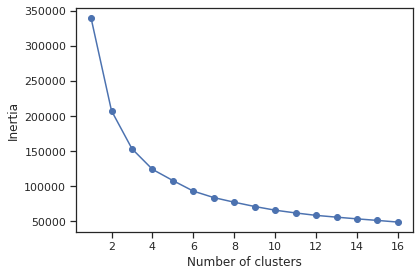

In [27]:
inertia_dr = []
elbow_method(X_train_dr, 1, 16, inertia_dr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


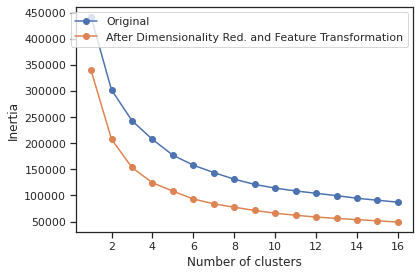

In [28]:
#Compare the inerertia reductions (elbow methods) of the original data vs. the  dimensionality-reduced version
  plt.plot(range(1, 16 + 1), inertia_original, marker='o', label="Original")
  plt.plot(range(1, 16 + 1), inertia_dr, marker='o', label="After Dimensionality Red. and Feature Transformation")
  ax = plt.subplot()
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.tight_layout()
  ax.legend()
  plt.show()

In [0]:
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10)
X_clustered = kmeans.fit_predict(X_train_dr)

In [30]:
centroids = kmeans.cluster_centers_
centroid_params = pl_dr.inverse_transform(centroids)
centroid_params_df = pd.DataFrame(data = centroid_params, columns=headers_dr)
centroid_params_df

,Bit Depth / Hole Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Movement: + / - / 0,Differential Pressure,Hook Load,On Bottom ROP,Standpipe Pressure,Convertible Torque
0,0.980025,70.987516,20.631044,342.962363,-0.001325,136.827664,222.004990,1.473821e+01,5023.477105,10.088635
1,0.997600,46.496402,19.131679,304.876342,-0.954697,756.062582,157.475450,1.332503e+02,3262.927288,8.395153
2,0.430845,1.762128,0.100869,4.049490,0.094102,0.184433,47.713662,-5.051959e-12,41.823827,1.578389
3,0.997453,23.603956,18.007645,265.204323,-0.030937,313.434471,189.349676,2.011659e+01,2650.742789,5.981001
4,0.999730,118.159793,33.524881,341.564366,-0.982493,1045.635236,208.154907,2.914634e+02,5957.695565,17.417940
5,0.531072,0.486334,145.954531,6.929537,-0.058650,0.187534,159.767124,-4.860112e-12,47.234370,0.742343


In [50]:
#Post clustering and visualization, perform further outlier removal.
orig_shape = X_dr.shape

X_dr_rm_highWOB = np.delete(X_dr, np.where(X_dr[:,2] > 50), 0)
removed_high_WOB = orig_shape[0] - X_dr_rm_highWOB.shape[0]

X_dr_rm_all_outliers = np.delete(X_dr_rm_highWOB, np.where(X_dr_rm_highWOB[:,5] > 2400), 0)
removed_diff_spike = X_dr_rm_highWOB.shape[0] - X_dr_rm_all_outliers.shape[0]

print(orig_shape)
print(removed_high_WOB)
print(removed_diff_spike)
print(X_dr_rm_all_outliers.shape)

(33984, 10)
5394
9
(28581, 10)


In [0]:
#Perform the elbow method again. Observe potential further decreases in inertia.
final_scaler = StandardScaler()
X_train_dr_final = final_scaler.fit_transform(X_dr_rm_all_outliers)

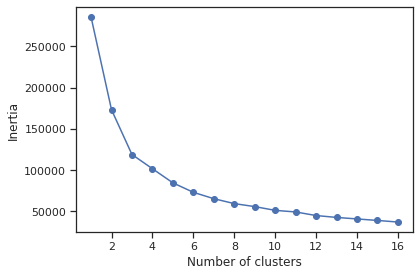

In [52]:
inertia_dr_remved_outliers = []
elbow_method(X_train_dr_final, 1, 16, inertia_dr_remved_outliers)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


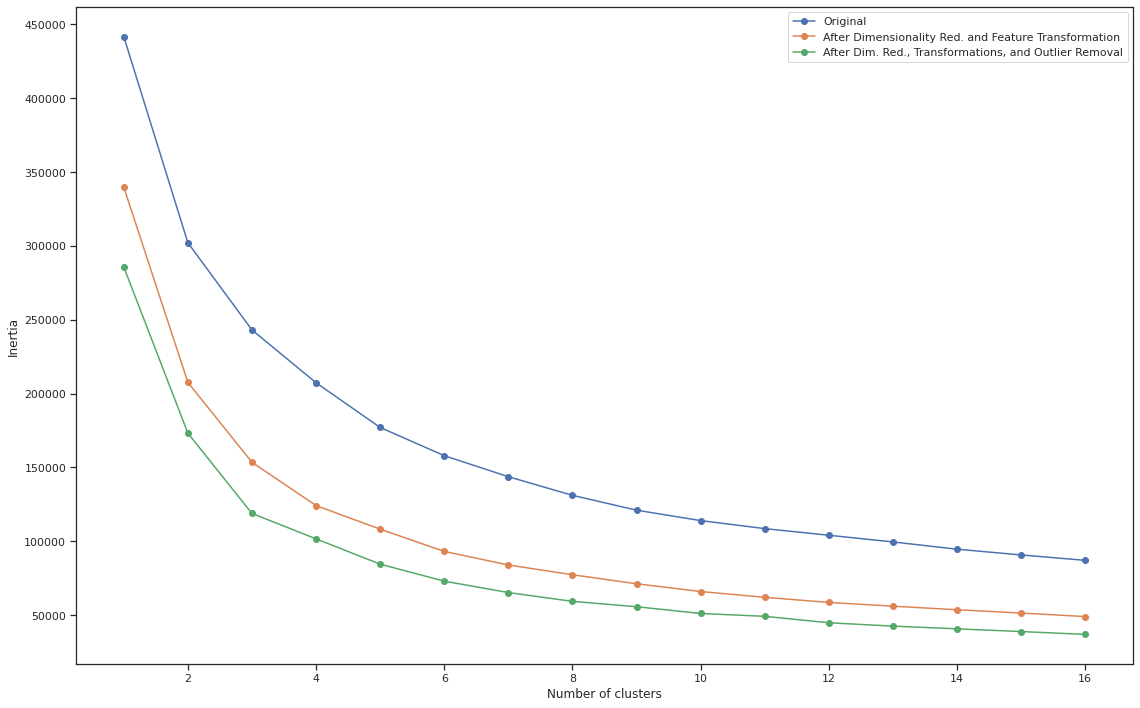

In [56]:
#Update inertia plot with removed outliers data set. 
#Compare the inerertia reductions (elbow methods) of the original data vs. the  dimensionality-reduced version
  plt.figure(figsize=(16, 10))
  plt.plot(range(1, 16 + 1), inertia_original, marker='o', label="Original")
  plt.plot(range(1, 16 + 1), inertia_dr, marker='o', label="After Dimensionality Red. and Feature Transformation")
  plt.plot(range(1, 16 + 1), inertia_dr_remved_outliers, marker='o', label="After Dim. Red., Transformations, and Outlier Removal")
  ax = plt.subplot()
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.tight_layout()
  ax.legend()
  plt.show()